### Imports

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import ImageGrab, Image
import time
from ipywidgets import Button, widgets
from IPython.display import display, clear_output, Image as PyImage
import threading
import subprocess
import pygetwindow as gw

### Get Image Testing Data

In [2]:
def load_images_from_directory(directory, target_size=(1024, 1024)):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            img = cv2.imread(os.path.join(directory, filename))
            if img is not None:
                # Resize image to target size
                img = cv2.resize(img, target_size)
                # Convert to RGB if the image is grayscale
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

# Load images and filenames
directory = 'data'
images, filenames = load_images_from_directory(directory)

# Convert to DataFrame if needed
df = pd.DataFrame({'filename': filenames, 'image': list(images)})

### Display Raw Images

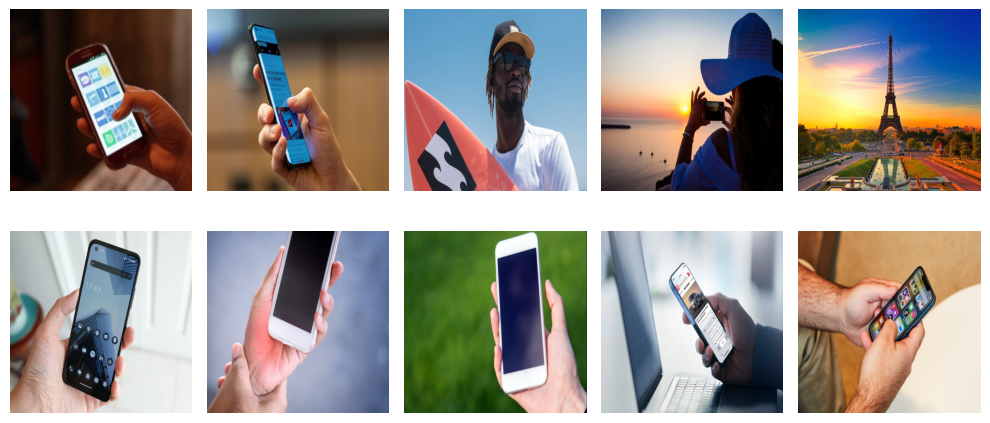

In [3]:
def display_images_in_grid(images, grid_shape=(5, 2), figsize=(10, 10), common_size=(100, 100)):
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    for ax, img in zip(axes.ravel(), images):
        resized_img = cv2.resize(img, common_size)  # Resize image to common size
        ax.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the images in a 5x2 grid
display_images_in_grid(images, grid_shape=(2, 5), figsize=(10, 5), common_size=(1024, 1024))

### Mask Everything but the Phone (Dhruv)

### Get Phone Screen Feed (Lucas)

In [ ]:
# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

try:
    # Continuously capture and display the scrcpy window
    while True:
        # Capture the window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)  # Create a bounding box in the format (left, top, right, bottom)
        screenshot = ImageGrab.grab(bbox)  # Use the correct bbox
    
        # Convert the screenshot to a numpy array
        frame = np.array(screenshot)
    
        # Convert RGB to BGR (required by OpenCV)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
        # Draw a red box in the center of the frame
        height, width, _ = frame.shape
        start_point = (width // 2 - 50, height // 2 - 50)
        end_point = (width // 2 + 50, height // 2 + 50)
        color = (0, 0, 255)  # Red in BGR
        thickness = 2
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
    
        # Display the frame
        _, encoded_frame = cv2.imencode('.jpg', frame)
        display(PyImage(data=encoded_frame.tobytes()))  # Use the Image function from IPython display
        clear_output(wait=True)
        
except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

### Get Computer Camera Feed (Lucas)

In [ ]:
# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:      
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        # Draw a red square in the middle of the frame
        height, width = frame.shape[:2]
        start_point = (width // 2 - 50, height // 2 - 50)  # top-left corner
        end_point = (width // 2 + 50, height // 2 + 50)    # bottom-right corner
        color = (0, 0, 255)  # BGR format for red
        thickness = 2
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)

        # Convert the frame to RGB format for display in Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(frame_rgb)

        # Display the frame
        clear_output(wait=True)
        
        display(im_pil)
        
        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the capture
cap.release()

### Display Camera Feed and Phone Screen Feed Side-by-Side

In [ ]:
# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:
        # Capture the scrcpy window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)
        screenshot = ImageGrab.grab(bbox)
        scrcpy_frame = np.array(screenshot)
        scrcpy_frame = cv2.cvtColor(scrcpy_frame, cv2.COLOR_RGB2BGR)

        # Draw a red box in the center of the scrcpy frame
        scrcpy_height, scrcpy_width, _ = scrcpy_frame.shape
        scrcpy_start_point = (scrcpy_width // 2 - 50, scrcpy_height // 2 - 50)
        scrcpy_end_point = (scrcpy_width // 2 + 50, scrcpy_height // 2 + 50)
        scrcpy_frame = cv2.rectangle(scrcpy_frame, scrcpy_start_point, scrcpy_end_point, (0, 0, 255), 2)

        # Capture frame-by-frame from the camera
        ret, camera_frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize the camera frame to match the height of the scrcpy frame
        camera_frame = cv2.resize(camera_frame, (int(camera_frame.shape[1] * scrcpy_height / camera_frame.shape[0]), scrcpy_height))

        # Draw a red square in the middle of the camera frame
        camera_height, camera_width = camera_frame.shape[:2]
        camera_start_point = (camera_width // 2 - 50, camera_height // 2 - 50)
        camera_end_point = (camera_width // 2 + 50, camera_height // 2 + 50)
        camera_frame = cv2.rectangle(camera_frame, camera_start_point, camera_end_point, (0, 0, 255), 2)

        # Combine the two frames horizontally
        combined_frame = np.hstack((scrcpy_frame, camera_frame))

        # Convert the combined frame to RGB format for display in Jupyter
        combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
        combined_im_pil = Image.fromarray(combined_frame_rgb)

        # Display the combined frame
        clear_output(wait=True)
        display(combined_im_pil)

        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the camera capture
cap.release()

### Detect When Phone is on Screen (Ethan)

In [ ]:
# Setup AlexNet


# Give AlexNet phone image


# Retrieve image label and coordinate of phone from AlexNet



### Overlay Phone Screen Feed onto Computer Camera Feed

In [17]:
# Target position and dimensions for overlay
target = [0.3, 0.5]
dimensions = [0.2, 0.5]

# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:        
        # Capture the scrcpy window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)
        screenshot = ImageGrab.grab(bbox)
        scrcpy_frame = np.array(screenshot)
        scrcpy_frame = cv2.cvtColor(scrcpy_frame, cv2.COLOR_RGB2BGR)

        # Capture frame-by-frame from the camera
        ret, camera_frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize and position the scrcpy frame according to target and dimensions
        camera_height, camera_width = camera_frame.shape[:2]
        scrcpy_width = int(camera_width * dimensions[0])
        scrcpy_height = int(camera_height * dimensions[1])
        scrcpy_frame = cv2.resize(scrcpy_frame, (scrcpy_width, scrcpy_height))
        top_left_x = int(camera_width * target[0] - scrcpy_width / 2)
        top_left_y = int(camera_height * target[1] - scrcpy_height / 2)
        camera_frame[top_left_y:top_left_y+scrcpy_height, top_left_x:top_left_x+scrcpy_width] = scrcpy_frame

        # Convert the camera frame to RGB format for display in Jupyter
        camera_frame_rgb = cv2.cvtColor(camera_frame, cv2.COLOR_BGR2RGB)
        camera_im_pil = Image.fromarray(camera_frame_rgb)

        # Display the camera frame with the overlay
        clear_output(wait=True)
        display(camera_im_pil)

        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the camera capture
cap.release()

Stream stopped.


### Identify Where Phone is in the Camera Feed

In [2]:
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np
from IPython.display import display, clear_output
from ipywidgets import widgets
from PIL import Image

# Initialize video capture from the default camera. Change '0' to a video file path to play a video file instead.
cap = cv2.VideoCapture(0)

# Create an output widget to display video frames in Jupyter notebooks.
output_widget = widgets.Output()
display(output_widget)  # Display the widget in the output of a cell.

# Define start and end points of a line for line crossing detection.
LINE_START = sv.Point(320, 0)
LINE_END = sv.Point(320, 480)

def lerp(start, end, alpha):
    return (1 - alpha) * start + alpha * end


def interpolate_boxes(start_box, end_box, num_frames):
    interpolated_boxes = []
    for frame in range(num_frames):
        alpha = frame / (num_frames - 1) if num_frames > 1 else 1
        interpolated_box = {
            'x': lerp(start_box['x'], end_box['x'], alpha),
            'y': lerp(start_box['y'], end_box['y'], alpha),
            'w': lerp(start_box['w'], end_box['w'], alpha),
            'h': lerp(start_box['h'], end_box['h'], alpha),
        }
        interpolated_boxes.append(interpolated_box)
    return interpolated_boxes

def draw_interpolated_box(frame, interpolated_box):
    top_left = (int(interpolated_box['x']), int(interpolated_box['y']))
    bottom_right = (int(interpolated_box['x'] + interpolated_box['w']), int(interpolated_box['y'] + interpolated_box['h']))
    color = (0, 255, 0)  # Green color for the box
    thickness = 2  # Thickness of the box lines

    # Draw the rectangle on the frame
    cv2.rectangle(frame, top_left, bottom_right, color, thickness)


def main():
    frame_count = 0  # Initialize frame counter to track when to update visually.
    last_visual_detection = None  # The last detection that was visually updated.
    current_visual_detection = None  # The current target for visual updating.
    update_interval = 5  # Number of frames over which to interpolate after a new detection.

    # Load the YOLO model for object detection.
    model = YOLO("yolov8l.pt")

    for result in model.track(source=0, show=True, stream=True, agnostic_nms=True, hide_labels=True):
        frame = result.orig_img  # Get the original image frame from the result.
        
        # Convert the class IDs and bounding boxes to NumPy arrays
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        boxes_xywh = result.boxes.xywh.cpu().numpy()

        new_detection = None
        for cls_id, box in zip(class_ids, boxes_xywh):
            if cls_id == 67:  # Check if the class ID is 67 (e.g., for a specific object)
                x, y, w, h = box
                # Adjust x, y to be the top-left corner of the box
                x -= w / 2
                y -= h / 2
                new_detection = {'w': w, 'h': h, 'x': x, 'y': y}
                break

        if new_detection:
            last_visual_detection = current_visual_detection if current_visual_detection else new_detection
            current_visual_detection = new_detection
            frame_count = 0
        else:
            # If no new detection, consider removing the visual detection after the update interval
            if frame_count >= update_interval:
                current_visual_detection = None  # This will stop the box from being drawn

        if current_visual_detection:
            if frame_count < update_interval and last_visual_detection:
                alpha = frame_count / update_interval
                interpolated_box = {
                    'x': lerp(last_visual_detection['x'], current_visual_detection['x'], alpha),
                    'y': lerp(last_visual_detection['y'], current_visual_detection['y'], alpha),
                    'w': lerp(last_visual_detection['w'], current_visual_detection['w'], alpha),
                    'h': lerp(last_visual_detection['h'], current_visual_detection['h'], alpha),
                }
                draw_interpolated_box(frame, interpolated_box)
            else:
                draw_interpolated_box(frame, current_visual_detection)
            frame_count += 1

        # Convert the frame to a PIL image and display it
        pil_image = Image.fromarray(frame)
        with output_widget:
            clear_output(wait=True)
            display(pil_image)

try:
    main()
except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the capture
cap.release()

Stream stopped.


### Overlay Phone Screen onto the Phone in the Camera Feed

In [2]:
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np
from IPython.display import display, clear_output
from ipywidgets import widgets
from PIL import Image, ImageGrab
import pygetwindow as gw

# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

# Initialize video capture from the default camera. Change '0' to a video file path to play a video file instead.
cap = cv2.VideoCapture(0)

# Create an output widget to display video frames in Jupyter notebooks.
output_widget = widgets.Output()
display(output_widget)  # Display the widget in the output of a cell.

# Define start and end points of a line for line crossing detection.
LINE_START = sv.Point(320, 0)
LINE_END = sv.Point(320, 480)

def lerp(start, end, alpha):
    return (1 - alpha) * start + alpha * end


def interpolate_boxes(start_box, end_box, num_frames):
    interpolated_boxes = []
    for frame in range(num_frames):
        alpha = frame / (num_frames - 1) if num_frames > 1 else 1
        interpolated_box = {
            'x': lerp(start_box['x'], end_box['x'], alpha),
            'y': lerp(start_box['y'], end_box['y'], alpha),
            'w': lerp(start_box['w'], end_box['w'], alpha),
            'h': lerp(start_box['h'], end_box['h'], alpha),
        }
        interpolated_boxes.append(interpolated_box)
    return interpolated_boxes

def draw_phone_screen(frame, interpolated_box):  
    try:
        # Extract the width, height, and top-left corner coordinates of the box
        box_w = int(interpolated_box['w'])
        box_h = int(interpolated_box['h'])
        x = int(interpolated_box['x'])
        y = int(interpolated_box['y'])

        # Capture the scrcpy window
        global scrcpy_window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)
        screenshot = ImageGrab.grab(bbox)
        scrcpy_frame = np.array(screenshot)
        scrcpy_frame = cv2.cvtColor(scrcpy_frame, cv2.COLOR_RGB2BGR)

        # Calculate the aspect ratio of the phone screen
        aspect_ratio = width / height

        # Calculate new dimensions for the phone screen that preserve the aspect ratio
        # and fit within the bounding box
        if box_w / box_h > aspect_ratio:
            # If the bounding box is wider than the aspect ratio, adjust the width
            new_w = int(box_h * aspect_ratio)
            new_h = box_h
        else:
            # If the bounding box is taller than the aspect ratio, adjust the height
            new_w = box_w
            new_h = int(box_w / aspect_ratio)

        # Resize the captured phone screen to the new dimensions
        resized_phone_screen = cv2.resize(scrcpy_frame, (new_w, new_h))

        # Calculate the position to center the resized phone screen within the bounding box
        center_x = x + (box_w - new_w) // 2
        center_y = y + (box_h - new_h) // 2

        # Overlay the resized phone screen onto the frame at the centered position
        frame[center_y:center_y+new_h, center_x:center_x+new_w] = resized_phone_screen

    except Exception as e:
        print(e)

def main():
    frame_count = 0  # Initialize frame counter to track when to update visually.
    last_visual_detection = None  # The last detection that was visually updated.
    current_visual_detection = None  # The current target for visual updating.
    update_interval = 3  # Number of frames over which to interpolate after a new detection.

    # Load the YOLO model for object detection.
    model = YOLO("yolov8l.pt")

    for result in model.track(source=0, show=False, verbose=False, stream=True, agnostic_nms=True, hide_labels=True):
        frame = result.orig_img  # Get the original image frame from the result.
        
        # Convert the class IDs and bounding boxes to NumPy arrays
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        boxes_xywh = result.boxes.xywh.cpu().numpy()

        new_detection = None
        for cls_id, box in zip(class_ids, boxes_xywh):
            if cls_id == 67:  # Check if the class ID is 67 (e.g., for a specific object)
                x, y, w, h = box
                # Adjust x, y to be the top-left corner of the box
                x -= w / 2
                y -= h / 2
                new_detection = {'w': w, 'h': h, 'x': x, 'y': y}
                break

        if new_detection:
            last_visual_detection = current_visual_detection if current_visual_detection else new_detection
            current_visual_detection = new_detection
            frame_count = 0
        else:
            # If no new detection, consider removing the visual detection after the update interval
            if frame_count >= update_interval:
                current_visual_detection = None  # This will stop the box from being drawn

        if current_visual_detection:
            if frame_count < update_interval and last_visual_detection:
                alpha = frame_count / update_interval
                interpolated_box = {
                    'x': lerp(last_visual_detection['x'], current_visual_detection['x'], alpha),
                    'y': lerp(last_visual_detection['y'], current_visual_detection['y'], alpha),
                    'w': lerp(last_visual_detection['w'], current_visual_detection['w'], alpha),
                    'h': lerp(last_visual_detection['h'], current_visual_detection['h'], alpha),
                }
                draw_phone_screen(frame, interpolated_box)
            else:
                draw_phone_screen(frame, current_visual_detection)
            frame_count += 1

        # Convert the frame to a PIL image and display it
        pil_image = Image.fromarray(frame)
        with output_widget:
            clear_output(wait=True)
            display(pil_image)

try:
    main()
except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")
finally:
    # When everything done, release the capture
    cap.release()
    print("Resources released.")

Stream stopped.
Resources released.


### Project Phone Screen Feed onto the Phone in the Camera Feed